# Mesh Comparison  
---
## Overview  
We conducted a series of experiments to investigate the role of connectivity between the grid and the mesh—an important factor for the encoder-decoder architecture. Four types of meshes were used: two with a uniform (grid-like) structure and two with a triangular structure. We evaluated the performance of each mesh type under varying numbers of connections between the grid and the mesh.

In this notebook, we compare the different meshes using the same number of edges between the grid and the mesh.

In [6]:
# Standard library imports
import re
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from enum import Enum
from typing import List, Dict, Tuple
from collections import defaultdict
from itertools import product, cycle, islice
from matplotlib.colors import ListedColormap
# First-party imports
sys.path.append(os.path.expanduser('~/Seacast'))
from src.seacast_tools.scoring_analysis import *
# Set up session settings
warnings.filterwarnings('ignore', category=FutureWarning)

# constants.py
# ---------------
# Create a Enums for different types
class NEdges(Enum):
    one = 1
    two = 2
    three = 3
    four = 4
    five = 5

class TypeMesh(Enum):
    crossing_edges = 'crossing_edges'
    non_crossing_edges = 'non_crossing_edges'
    bathymetry = 'bathymetry'
    fps = 'fps'

class TypeScore(Enum):
    RMSE = 'SquaredError'
    MAE = 'AbsoluteError'
    Bias = 'Error'

class TypeVariable(Enum):
    sst_temperature = 'sst_temperature'

# plotting_utils.py
# -----------------
# Create a custom colormap
def create_colormap(cmap: str, n_colors: int, alpha: float) -> ListedColormap:
    """Create a custom colormap with specified number of colors and alpha transparency.
    """
    base_cmap = plt.get_cmap(cmap)
    colors = base_cmap(np.arange(n_colors))
    colors[:, 3] = alpha
    return colors

# Repeat colors in an array
def repeat_colors(colors: np.ndarray, n_repeats: int) -> np.ndarray:
    """Repeat the colors in the array n_repeats times.
    """
    return np.array(list(colors) * n_repeats)
# Generate offsets for multiplayer plotting
def gen_multiplayer_offsets(mesh_types: TypeMesh, num_cycles: int) -> cycle:  
    """Generate offsets for plotting based on the number of mesh types.
    """
    offsets = np.arange(-len(mesh_types)/2, len(mesh_types)/2)
    return islice(cycle(offsets), len(offsets) * num_cycles)

# data_processing.py
# ------------------
# Convert experiments to a nested dictionary of statistics
def as_stats_dict(
    experiments: List[StatsLoader]
    ) -> Dict[NEdges, Dict[TypeMesh, Dict[TypeScore, Dict[TypeVariable, xr.DataArray]]]]:
    """Convert a list of experiments into a nested dictionary of statistics grouped by:
        - The last character of the experiment name (assumed to be an integer).
        - The substring of the experiment name before the first occurrence of '_m'.
    """
    patron = r'^.*?(?=_m)'
    d = defaultdict(dict)
    for exp in experiments:
        with StatsAggSession(exp) as stats:
            lead_time_scores = stats.agg_scores(
                ['init_time', 'latitude', 'longitude']
                )
            key_1 = NEdges(int(exp.name[-1]))
            key_2 = TypeMesh(re.search(patron, exp.name).group(0))
            d[key_1][key_2] = lead_time_scores
    return d

# plotting.py
# -----------
# Plot lead time scores for different mesh types
def plot_scores(
    exp_dic: Dict[NEdges, Dict[TypeMesh, Dict[TypeScore, Dict[TypeVariable, xr.DataArray]]]],
    g2m_connections: NEdges,
    ) -> None:
    # Number of rows for the plot grid depending on the number of scores
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))
    axs = axs.flatten()
    for mesh in TypeMesh:
        data = exp_dic[g2m_connections][mesh]
        score_names = [score.value for score in list(TypeScore)]
        variable_names = [var.value for var in list(TypeVariable)]
        axs = plot_lead_time_scores(
            mesh.value, 
            score_names, 
            variable_names, 
            data, 
            axs
            )
    fig.suptitle(f"Lead Time Scores - grid to mesh connections: {g2m_connections.value}")
# Plot lead time scores for different mesh types
def plot_rmse(
    exp_dic: Dict[NEdges, Dict[TypeMesh, Dict[TypeScore, Dict[TypeVariable, xr.DataArray]]]],
    g2m_connections: NEdges,
    axs: plt.Axes = None,
    ) -> Tuple[plt.Figure, plt.Axes]:
    # Number of rows for the plot grid depending on the number of scores
    
    for mesh in TypeMesh:
        # Plot a specific score and variable for all experiments
        score = TypeScore.RMSE.value
        variable = TypeVariable.sst_temperature.value
        data = exp_dic[g2m_connections][mesh][score][variable]
        # Plot each score and variable in the grid
        lead_days = data.lead_time.data.astype('timedelta64[D]')
        axs.plot(lead_days, data.data, marker='o', linestyle='-', label=mesh.value)
        axs.set_xlabel("Lead Time (days)")
        axs.set_ylabel(f"{score} - {variable} (K)")
        axs.set_title(f"Lead Time RMSE - grid to mesh connections: {g2m_connections.value}")
        axs.legend()
    return axs

def barplot_mean_std(
    stats_dic: Dict[NEdges, Dict[TypeMesh, Dict[TypeScore, Dict[TypeVariable, xr.DataArray]]]],
    axs: plt.Axes = None,
    ) -> None:
    # Extraer etiquetas y calcular media y desviación estándar para cada categoría
    labels = list(stats_dic.keys())
    means = [np.mean([item.item() for item in stats_dic[label]]) for label in labels]
    stds = [np.std([item.item() for item in stats_dic[label]]) for label in labels]

    print("Labels:", labels)
    print("Means:", means)
    print("SD:", stds)

    # 'yerr' toma la lista de desviaciones estándar para dibujar las barras de error
    bars = axs.bar(labels, means, yerr=stds, capsize=5, color='teal', alpha=0.7)

    # Añadir etiquetas a las barras
    axs.bar_label(bars, fmt='%.2f', label_type='center')

    # Añadir etiquetas y título
    axs.set_title('Media de los Datos con Desviación Estándar')
    axs.set_ylabel('Valor de la Media')
    axs.set_xlabel('Categorías')
    axs.grid(axis='y', linestyle='--', alpha=0.6)
    axs.tick_params(axis='x', rotation=45)

    plt.tight_layout()

    return axs

In [7]:
# Folder where figures will be saved    
FIGURE_FOLDER = os.path.expanduser('~/Seacast/reports/figures')

## Barplot
---

In [8]:
%%time
experiments_names = [
    'crossing_edges_m_5_3_g2mm2g_1',
    'non_crossing_edges_m_5_3_g2mm2g_1',
    'bathymetry_m_14_6_g2mm2g_1',
    'fps_m_14_6_g2mm2g_1',
    'crossing_edges_m_5_3_g2mm2g_2',
    'non_crossing_edges_m_5_3_g2mm2g_2',
    'bathymetry_m_14_6_g2mm2g_2',
    'fps_m_14_6_g2mm2g_2',
    'crossing_edges_m_5_3_g2mm2g_3',
    'non_crossing_edges_m_5_3_g2mm2g_3',
    'bathymetry_m_14_6_g2mm2g_3',
    'fps_m_14_6_g2mm2g_3',
    'crossing_edges_m_5_3_g2mm2g_4',
    'non_crossing_edges_m_5_3_g2mm2g_4',
    'bathymetry_m_14_6_g2mm2g_4',
    'fps_m_14_6_g2mm2g_4',
    'crossing_edges_m_5_3_g2mm2g_5',
    'non_crossing_edges_m_5_3_g2mm2g_5',
    'bathymetry_m_14_6_g2mm2g_5',
    'fps_m_14_6_g2mm2g_5',
    ]

experiments = [
    StatsLoader(os.path.join("~/Seacast/output/exps_g2m", exp_name)) 
    for exp_name in experiments_names
    ]
# Create a dictionary of experiments grouped by the last character of the experiment name
exp_dic = as_stats_dict(experiments)  

CPU times: user 3min 24s, sys: 3min 23s, total: 6min 48s
Wall time: 6min 48s


CPU times: user 188 ms, sys: 12.1 ms, total: 200 ms
Wall time: 198 ms


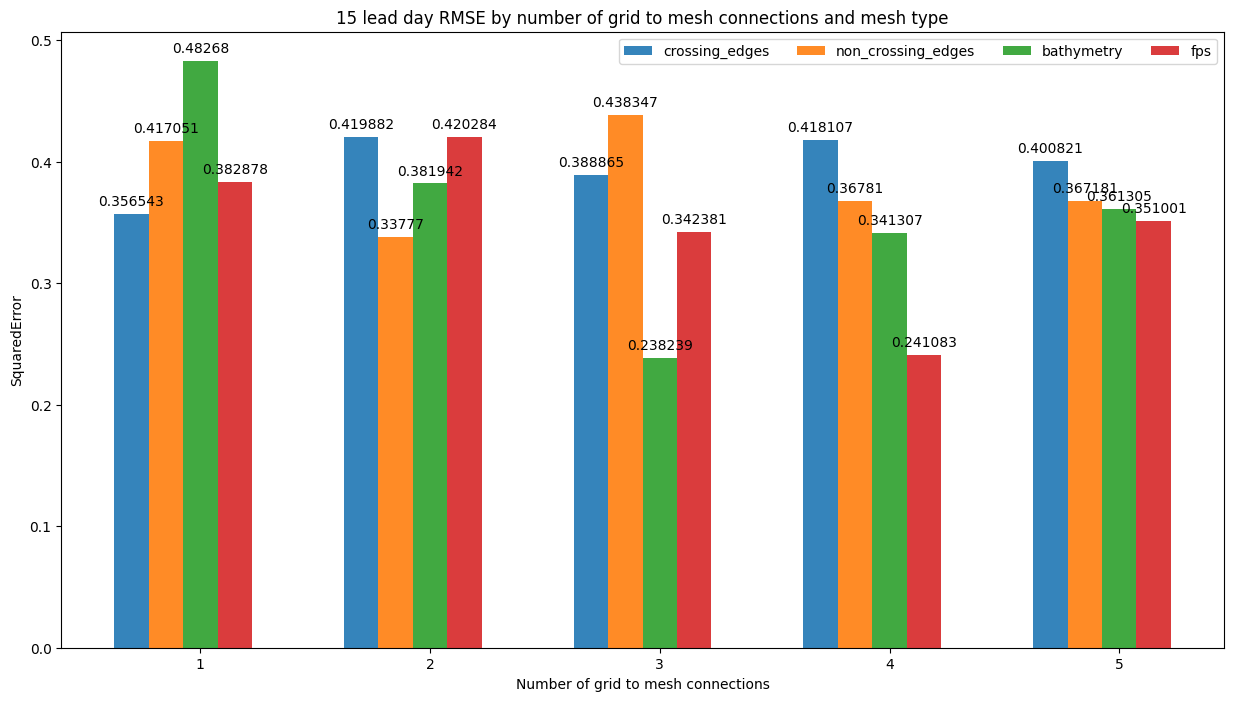

In [6]:
%%time
# Number of rows for the plot grid depending on the number of scores
fig, axs = plt.subplots(1, 1, figsize=(15, 8))
# Define the width of the bars
width = 0.15  # the width of the bars
# Plot a specific score and variable for all experiments
score = TypeScore.RMSE.value
variable = TypeVariable.sst_temperature.value
base_cmap = create_colormap("tab10", len(TypeMesh), 0.9)

for (edge, mesh), multiplier, color in zip(
    product(list(NEdges), list(TypeMesh)), 
    gen_multiplayer_offsets(TypeMesh, len(NEdges)),
    repeat_colors(base_cmap, len(NEdges))
    ):
    data = exp_dic[edge][mesh][score][variable]
    last_day_data = data.isel(lead_time=-1)  
    offset = width * multiplier
    rects = axs.bar(
        edge.value + offset, 
        last_day_data.data, 
        width, 
        label=mesh.value if edge == NEdges.one else "", 
        color=color
        )
    axs.bar_label(rects, padding=len(TypeMesh))

# Add some text for labels, title and custom x-axis tick labels, etc.
axs.set_ylabel(score)
axs.set_xlabel('Number of grid to mesh connections')
axs.set_title('15 lead day RMSE by number of grid to mesh connections and mesh type')
axs.legend(loc='upper right', ncols=len(TypeMesh))
# Save the figure
fig.savefig(os.path.join(FIGURE_FOLDER, 'rmse_by_g2m_and_mesh_type.pdf'), dpi=300)

Labels: ['crossing_edges', 'non_crossing_edges', 'bathymetry', 'fps']
Means: [np.float64(0.39684359431266786), np.float64(0.38563205003738404), np.float64(0.361094543337822), np.float64(0.34752555191516876)]
SD: [np.float64(0.023179565657365248), np.float64(0.03664674596773281), np.float64(0.07836149371105099), np.float64(0.05985320423967342)]
CPU times: user 384 ms, sys: 19.7 ms, total: 404 ms
Wall time: 400 ms


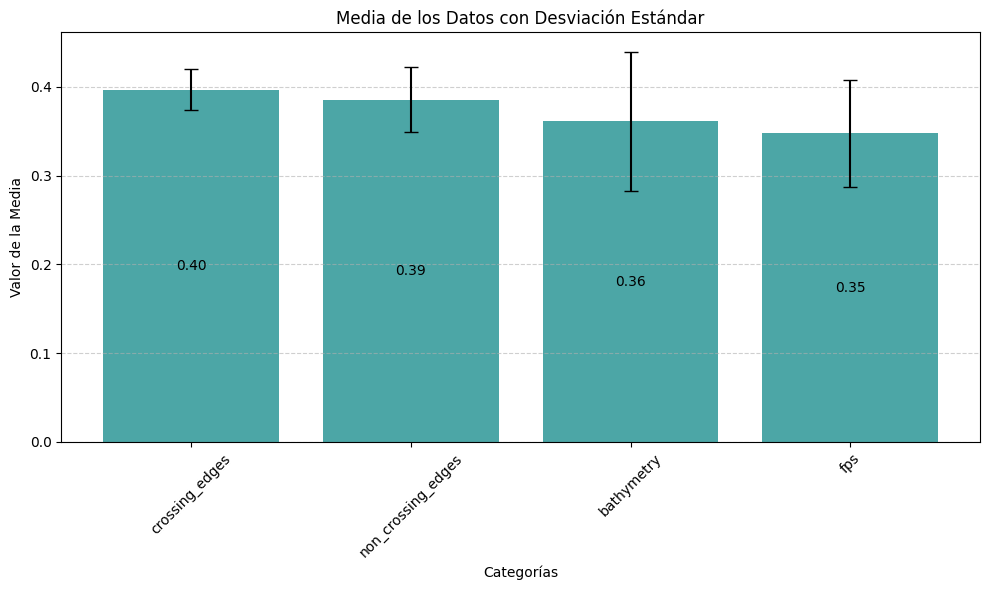

In [110]:
%%time
# Plot a specific score and variable for all experiments
score = TypeScore.RMSE.value
variable = TypeVariable.sst_temperature.value
agg_by_mesh = defaultdict(list)
for (edge, mesh) in product(list(NEdges), list(TypeMesh)):
    data = exp_dic[edge][mesh][score][variable]
    last_day_data = data.isel(lead_time=-1)
    agg_by_mesh[mesh.value].append(last_day_data.data)
# stats_by_mesh = {
#     k: {"mean": np.mean(v).item(), "std": np.std(v).item()}
#     for k, v in agg_by_mesh.items()
# }
# Crear un gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))
barplot_mean_std(agg_by_mesh, axs=ax)
fig.savefig(os.path.join(FIGURE_FOLDER, f'rmse_avg_by_mesh.pdf'), dpi=300)
fig.savefig(os.path.join(FIGURE_FOLDER, f'rmse_avg_by_mesh.png'), dpi=300)

Labels: [1, 2, 3, 4, 5]
Means: [np.float64(0.4097881019115448), np.float64(0.38996945321559906), np.float64(0.3519582189619541), np.float64(0.34207693114876747), np.float64(0.3700769692659378)]
SD: [np.float64(0.04723629403272184), np.float64(0.03392243655125261), np.float64(0.07390706774997788), np.float64(0.06450388593870499), np.float64(0.01867096924376056)]
CPU times: user 404 ms, sys: 25.2 ms, total: 429 ms
Wall time: 428 ms


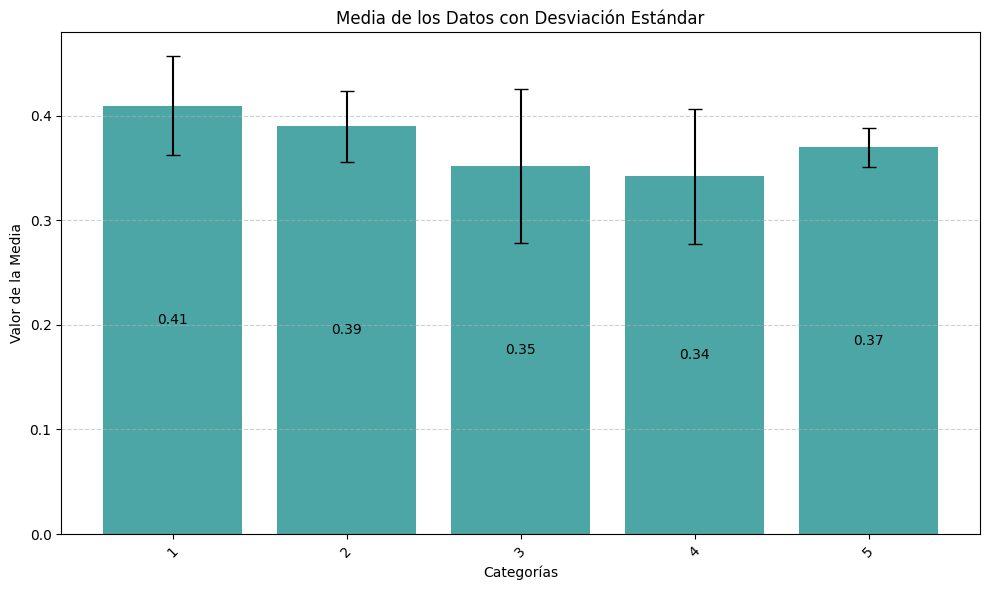

In [109]:
%%time
# Plot a specific score and variable for all experiments
score = TypeScore.RMSE.value
variable = TypeVariable.sst_temperature.value
agg_by_edge = defaultdict(list)
for (edge, mesh) in product(list(NEdges), list(TypeMesh)):
    data = exp_dic[edge][mesh][score][variable]
    last_day_data = data.isel(lead_time=-1)
    agg_by_edge[edge.value].append(last_day_data.data)
# Crear un gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))
barplot_mean_std(agg_by_edge, axs=ax)
fig.savefig(os.path.join(FIGURE_FOLDER, f'rmse_avg_by_edge.pdf'), dpi=300)
fig.savefig(os.path.join(FIGURE_FOLDER, f'rmse_avg_by_edge.png'), dpi=300)


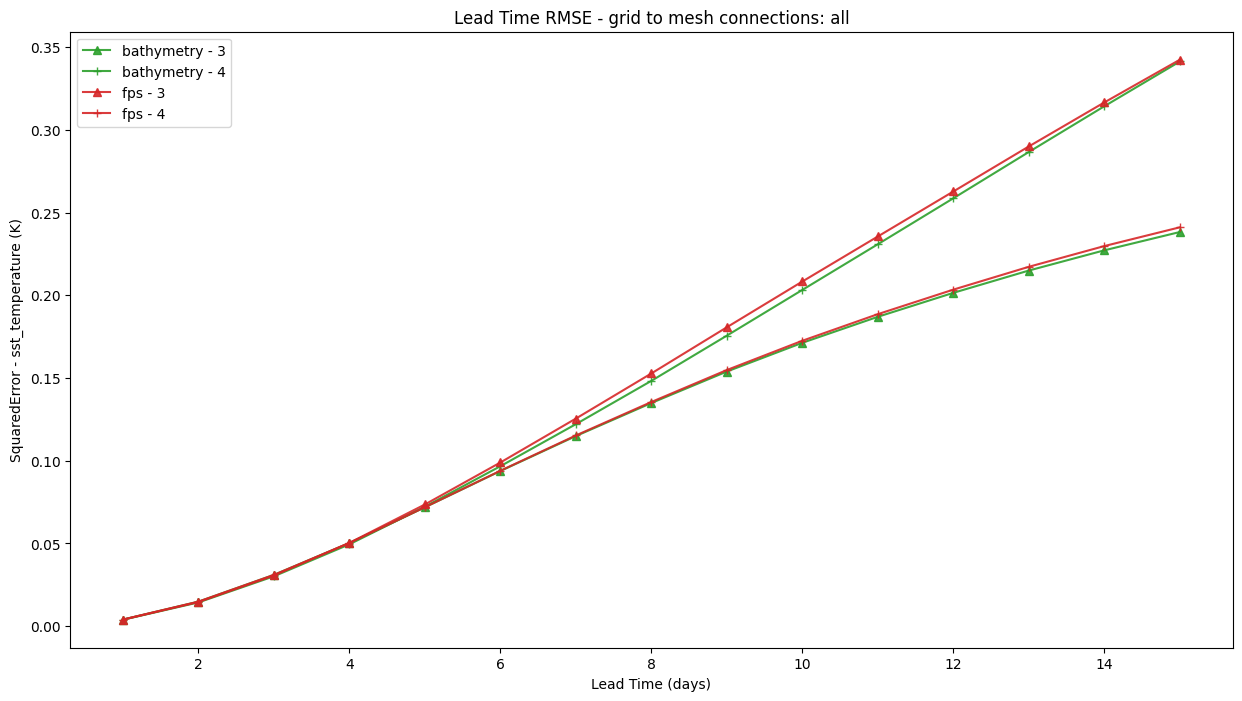

In [103]:
# Number of rows for the plot grid depending on the number of scores
fig, axs = plt.subplots(1, 1, figsize=(15, 8))
base_cmap = create_colormap(
    "tab10",
    #"tab20c", 
    len(TypeMesh) * len(NEdges), 
    0.9
    )
base_cmap_as_iter = iter(base_cmap)
marker_styles = ['s', 'o', '^', '+', '*']
# Plot a specific score and variable for all experiments
for mesh, color in zip(TypeMesh, base_cmap_as_iter):

    # Number of rows for the plot grid depending on the number of scores
    if (
        mesh == TypeMesh.crossing_edges
        or mesh == TypeMesh.non_crossing_edges
        #or mesh == TypeMesh.bathymetry
       
        ):
        continue        
    for g2m_connections, marker in zip(NEdges, marker_styles):
        if (
            g2m_connections == NEdges.one 
            or g2m_connections == NEdges.two 
            or g2m_connections == NEdges.five
        ):
            continue
        # Plot a specific score and variable for all experiments
        score = TypeScore.RMSE.value
        variable = TypeVariable.sst_temperature.value
        data = exp_dic[g2m_connections][mesh][score][variable]
        # Plot each score and variable in the grid
        lead_days = data.lead_time.data.astype('timedelta64[D]')
        axs.plot(lead_days, data.data, marker=marker, linestyle='-', label=f"{mesh.value} - {g2m_connections.value}", color=color)
        axs.set_xlabel("Lead Time (days)")
        axs.set_ylabel(f"{score} - {variable} (K)")
        axs.set_title(f"Lead Time RMSE - grid to mesh connections: all")
        axs.legend()

fig.savefig(os.path.join(FIGURE_FOLDER, f'fps_vs_bathymetry.pdf'), dpi=300)
fig.savefig(os.path.join(FIGURE_FOLDER, f'fps_vs_bathymetry.png'), dpi=300)


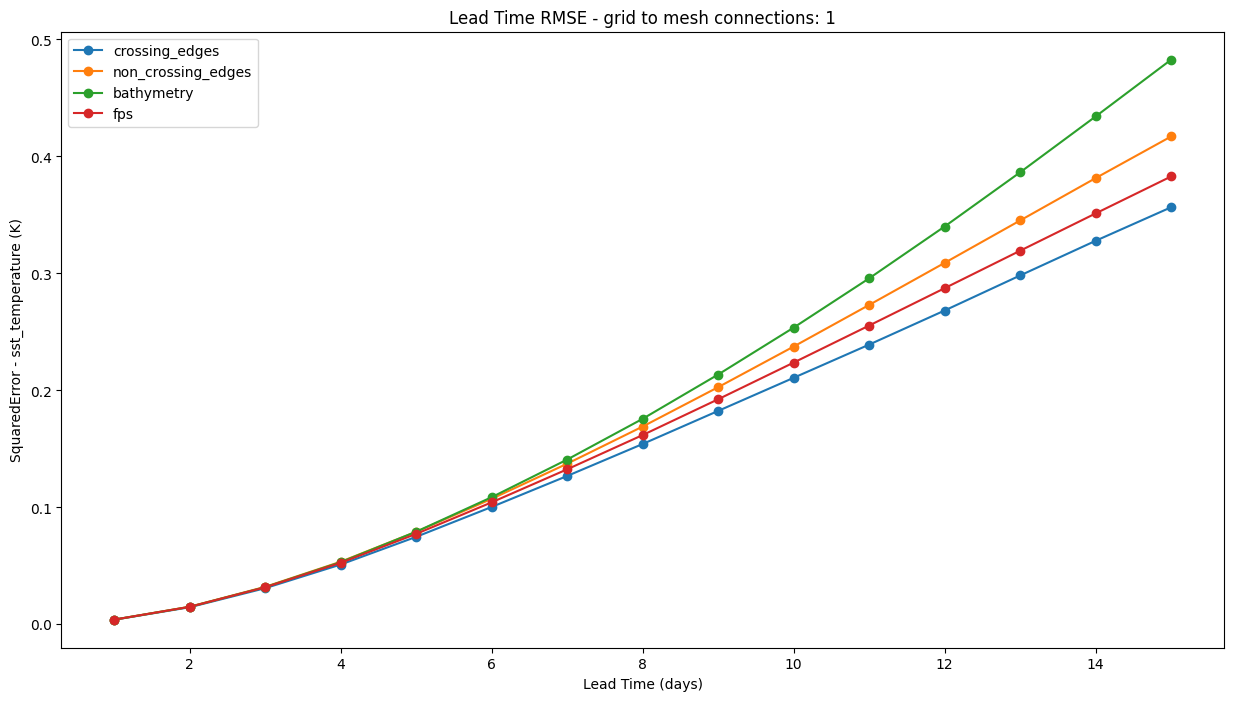

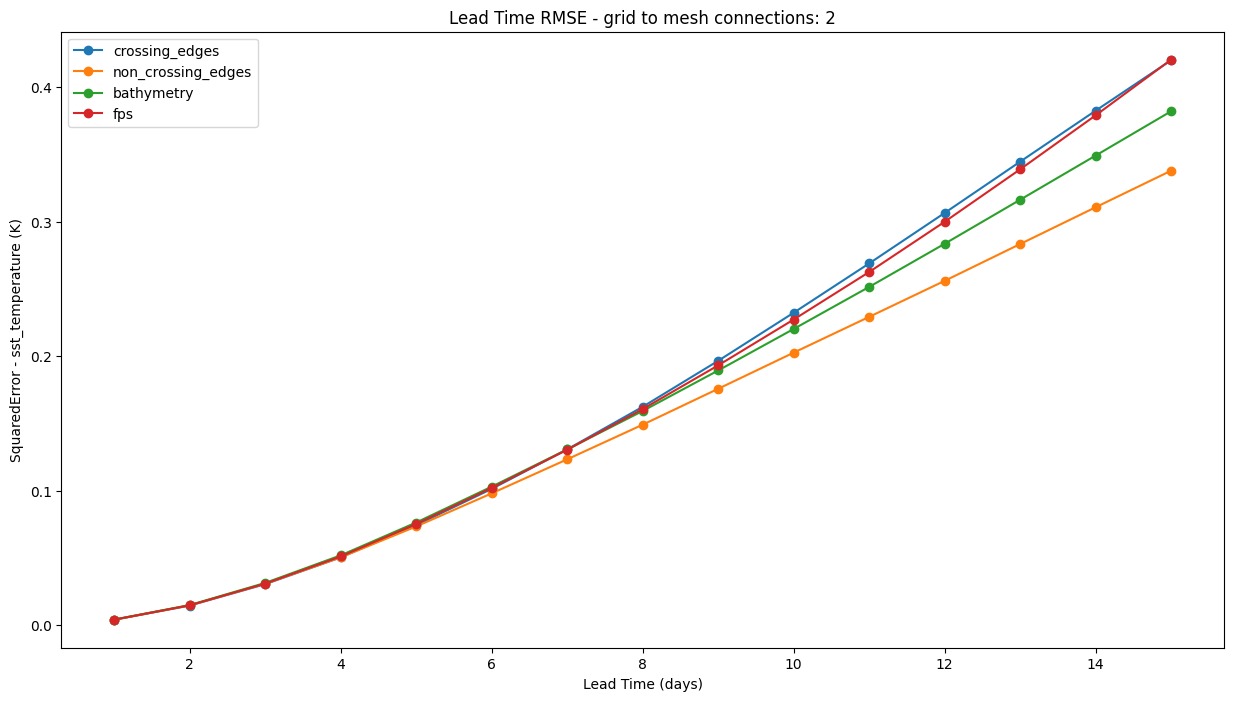

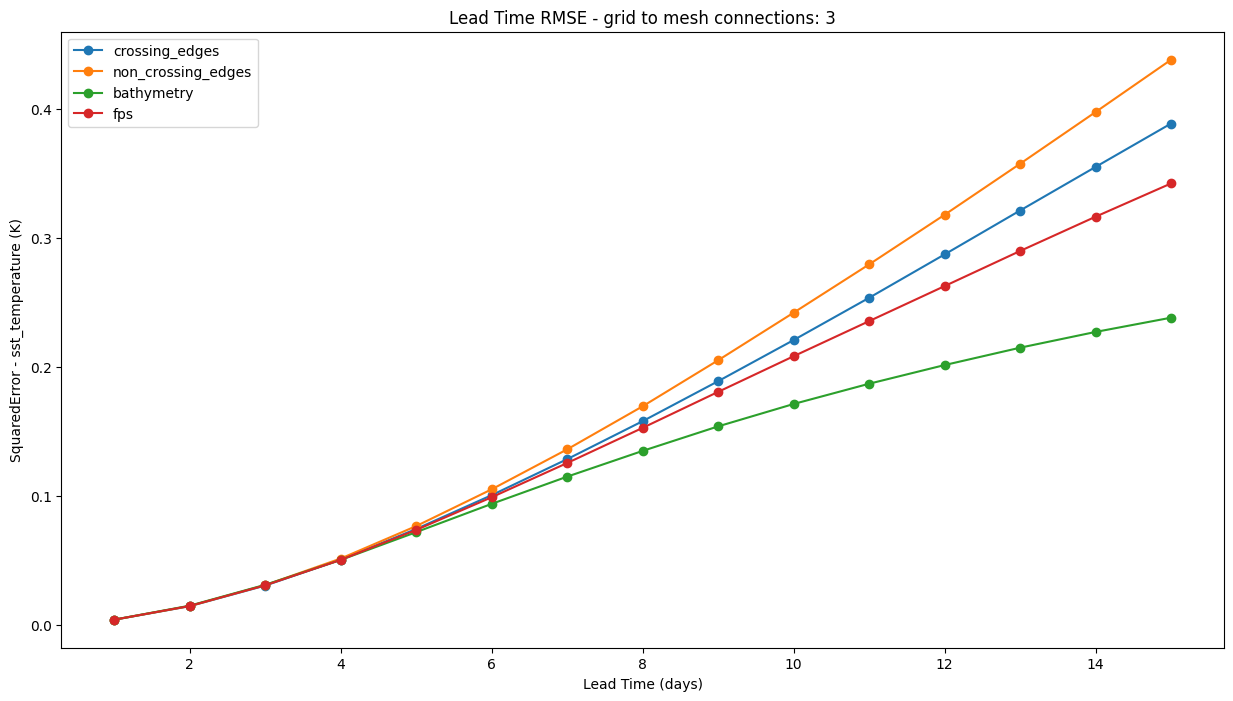

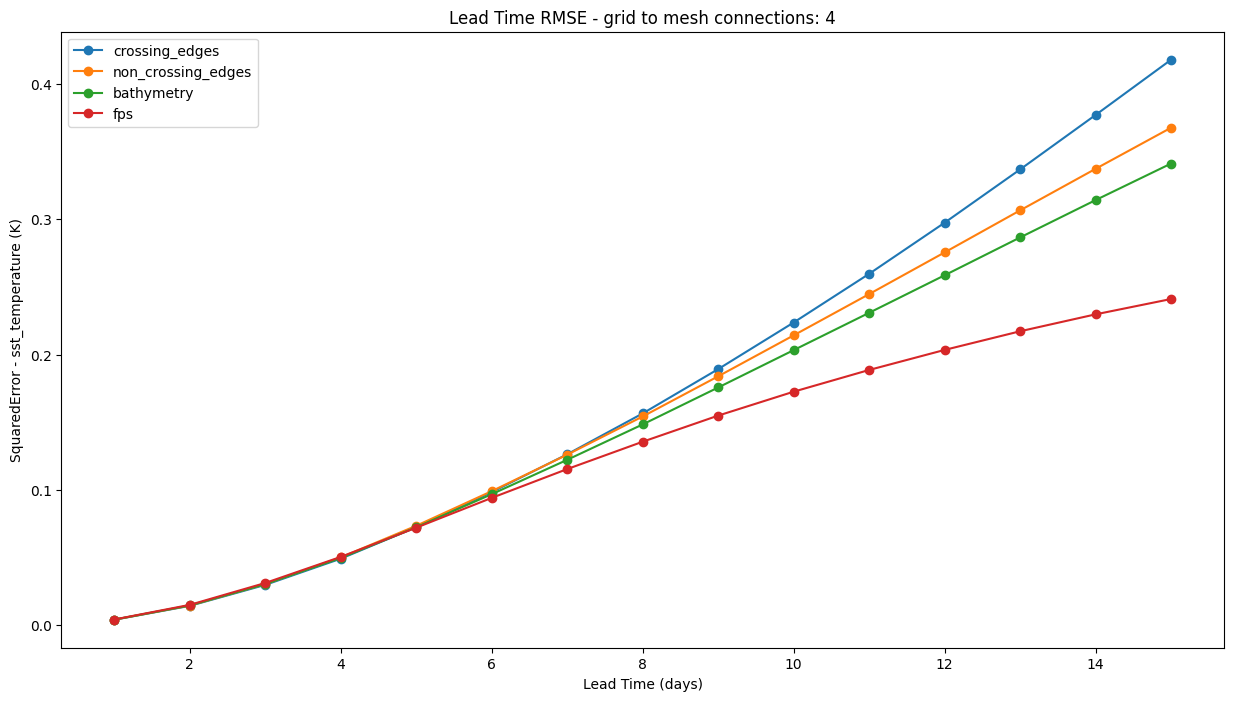

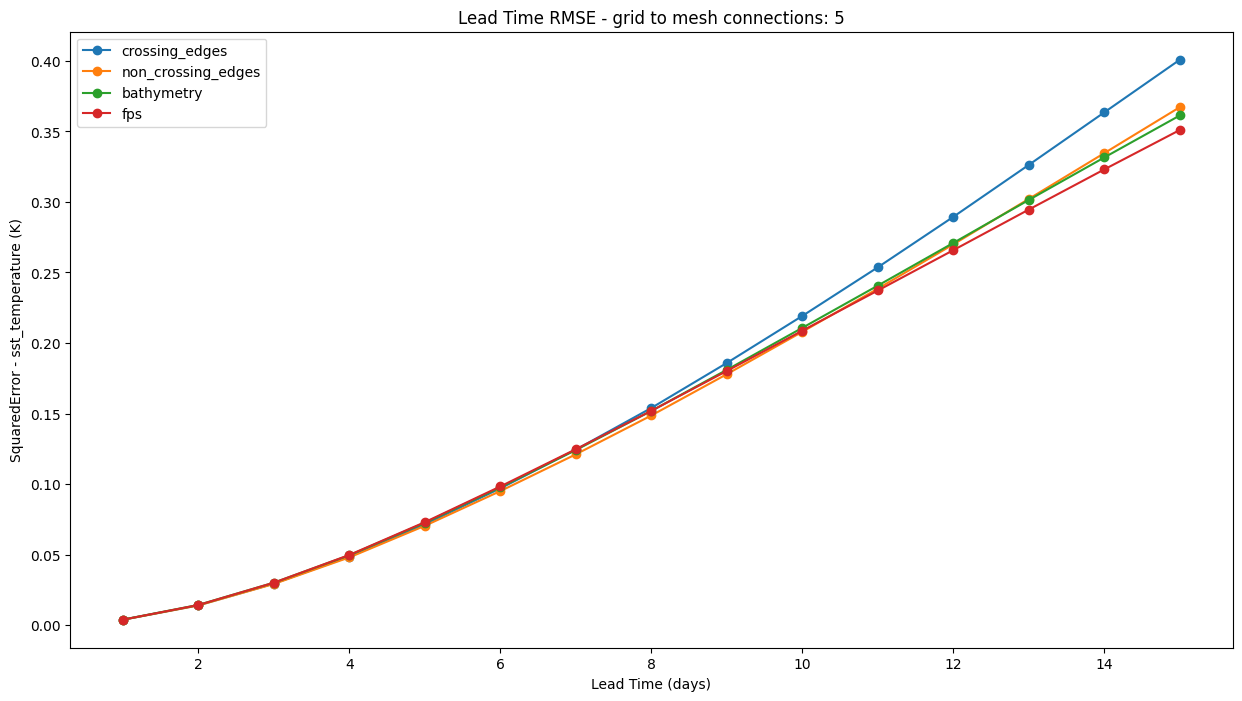

In [ ]:
# Number of rows for the plot grid depending on the number of scores
for g2m_connections in NEdges:
    fig, axs = plt.subplots(1, 1, figsize=(15, 8))

    axs = plot_rmse(exp_dic, g2m_connections, axs)
    # Save the figure
    fig.savefig(os.path.join(FIGURE_FOLDER, f'rmse_g2m_{g2m_connections.value}.pdf'), dpi=300)


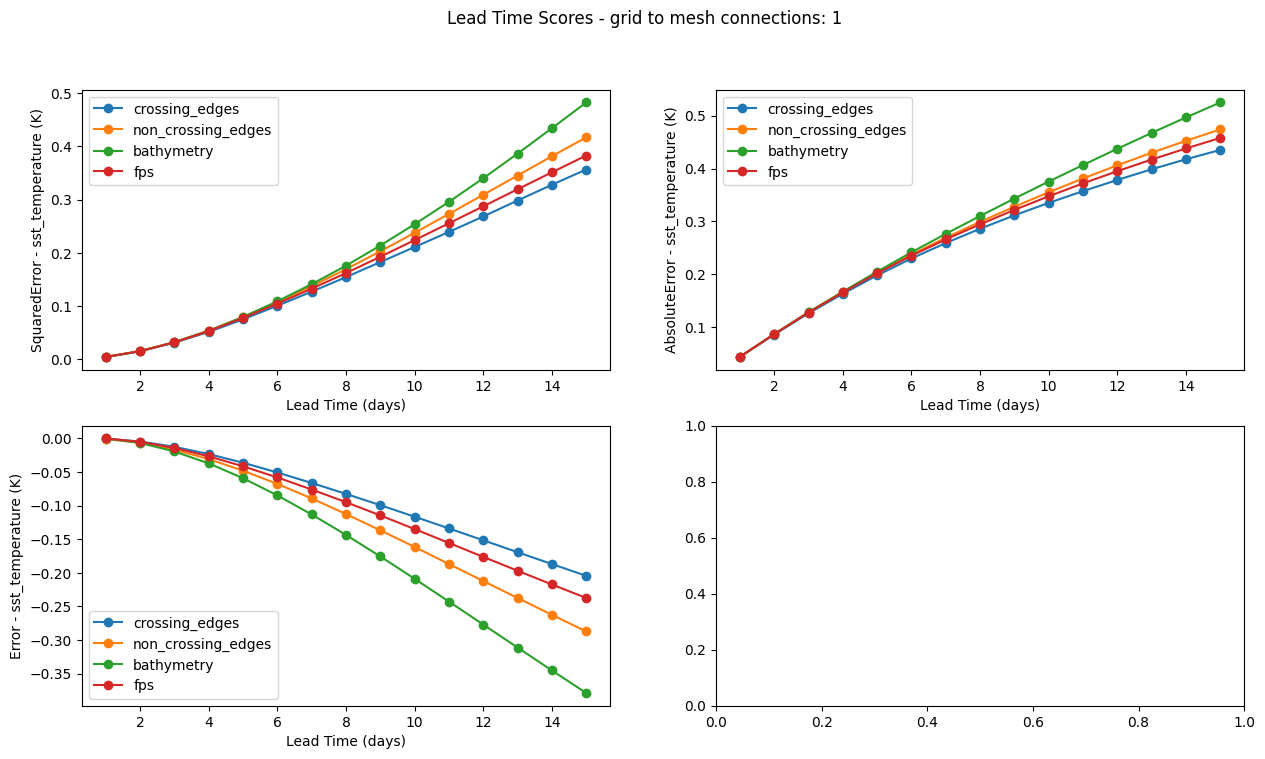

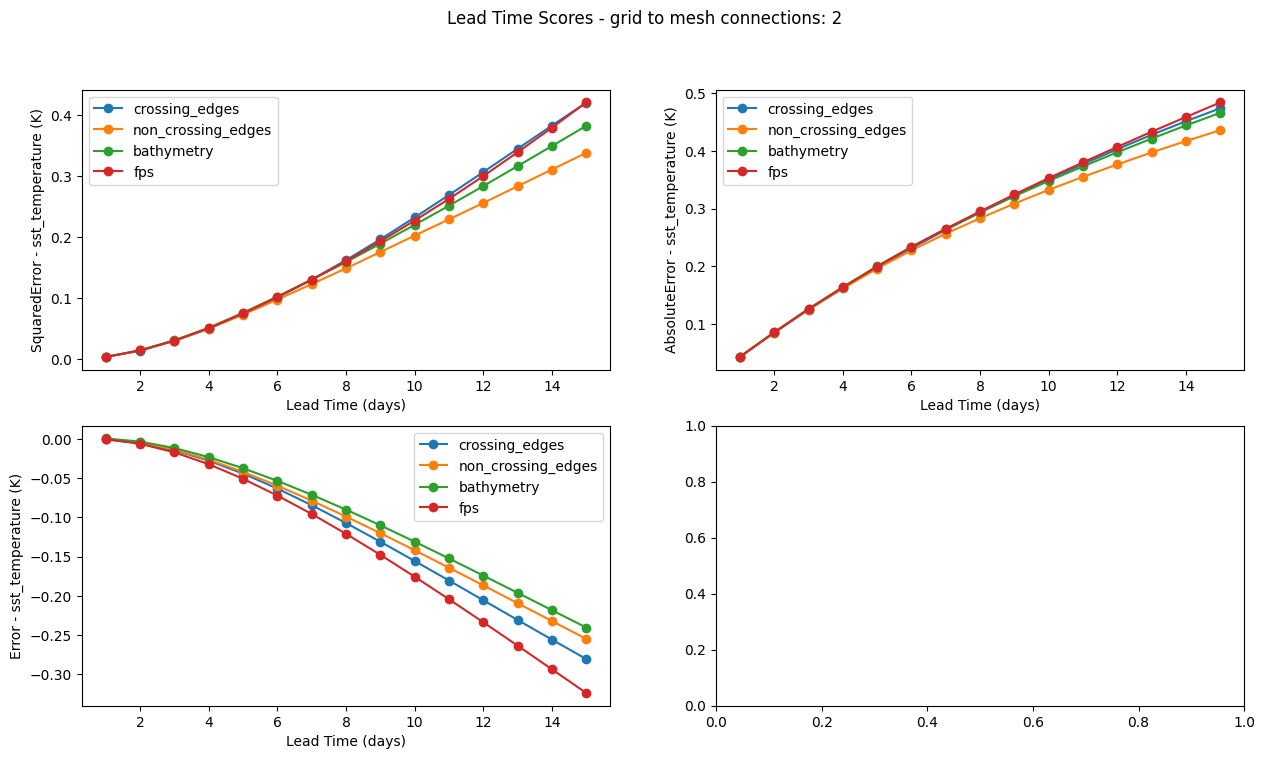

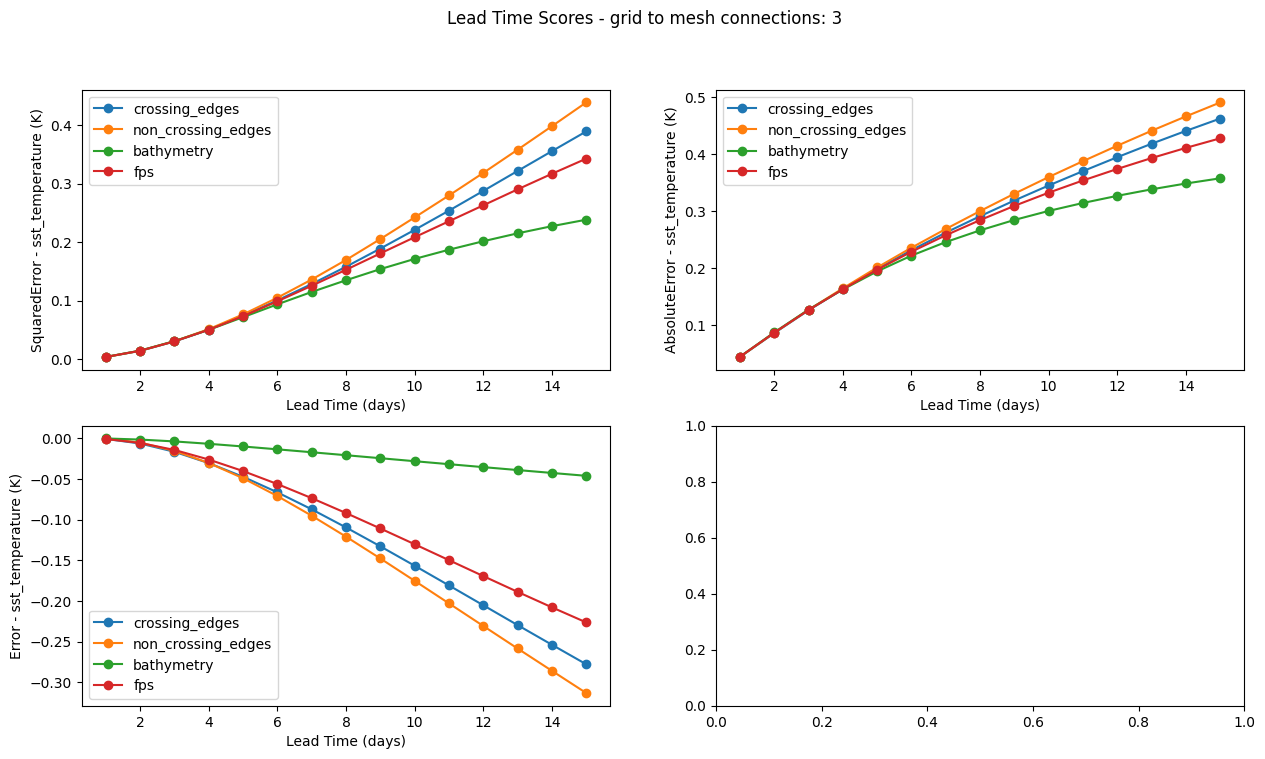

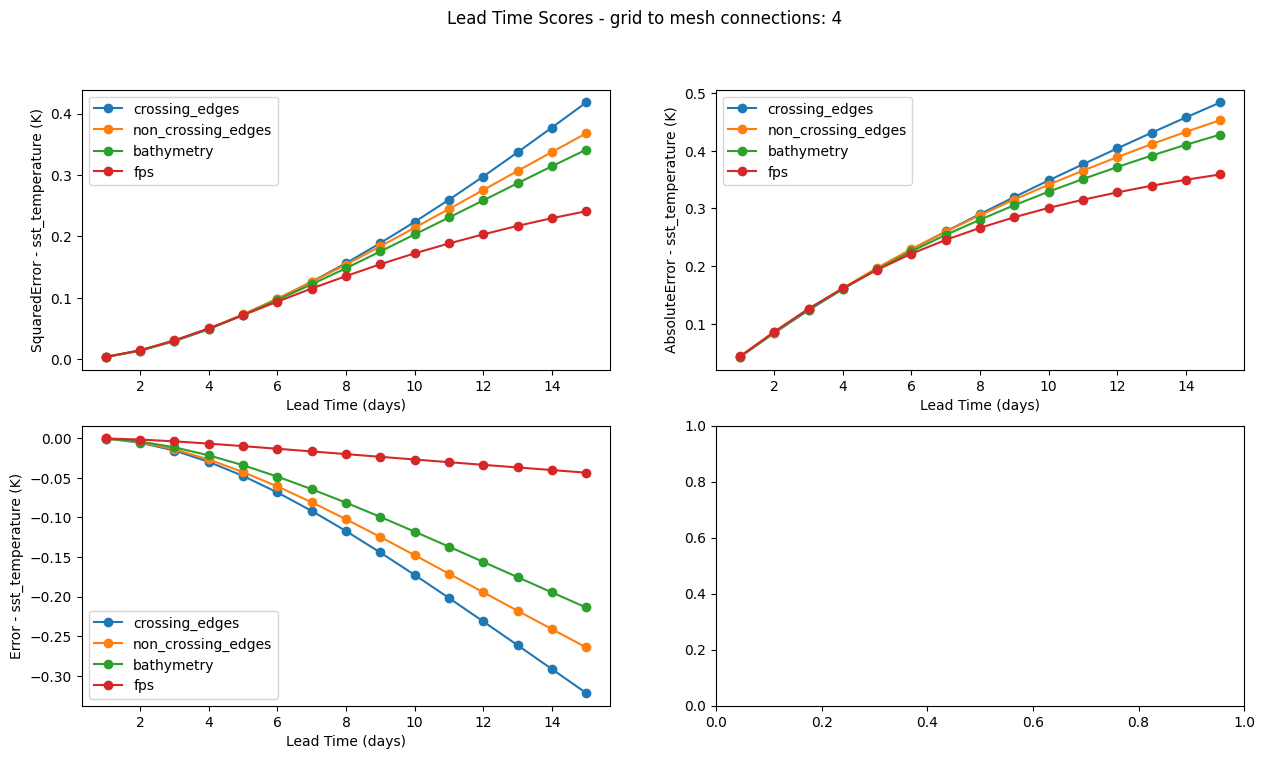

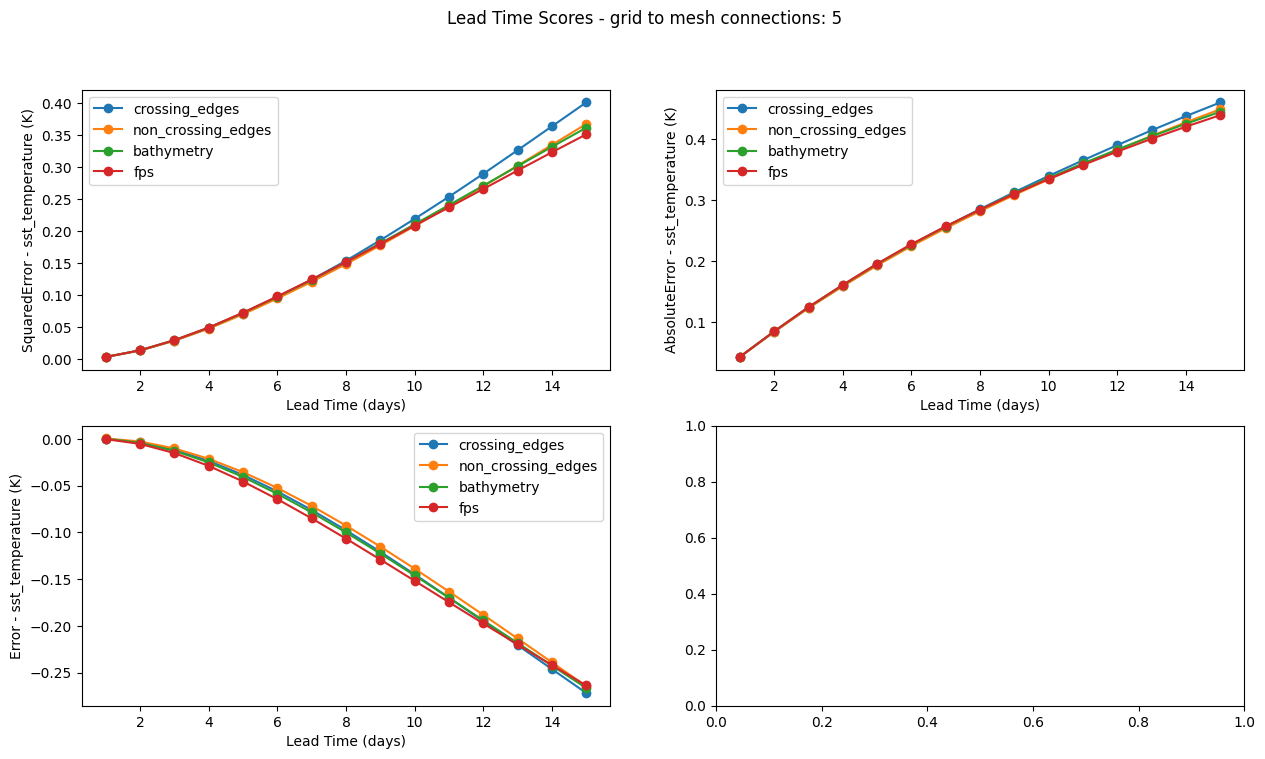

In [8]:
# Number of rows for the plot grid depending on the number of scores
for g2m_connections in NEdges:
    plot_scores(exp_dic, g2m_connections)